# Notebook 4: Model Usage / Evaluation and Testing Use Case

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.8 MB/s eta 0:00:00


In [13]:
from transformers import AutoModelForTokenClassification
from transformers import AutoTokenizer
import torch
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc="Progress")

In [14]:
model_save_path = '/content/drive/Shareddrives/TM_project/saved_models/model_v1'
tokenizer_save_path = '/content/drive/Shareddrives/TM_project/saved_models/tokenizer_v1'

In [15]:
model=AutoModelForTokenClassification.from_pretrained(model_save_path)
tokenizer=AutoTokenizer.from_pretrained(tokenizer_save_path)

In [ ]:
df1=pd.read_parquet("/content/drive/Shareddrives/TM_project/transformed_data.parquet")

In [ ]:
flattened_sentences = []
tags = []
job_ids = []

# Iterating over each row in the DataFrame
for index, row in df1.iterrows():
    # Iterating over each sentence and tag in the lists
    for sentence, tag in zip(row['Tokenized Description'], row['tags']):
        job_ids.append(row['Job Id'])
        flattened_sentences.append(sentence)
        tags.append(tag)

# Creating a new DataFrame from the flattened lists
data = pd.DataFrame({
    "Job Id": job_ids,
    "Sentence": flattened_sentences
})

data

,Job Id,Sentence
0,1,"[overview, reporting, director, data, integrat..."
1,1,"[individual, expected, key, contributor, ideat..."
2,1,"[position, play, important, role, producing, d..."
3,1,"[opportunity, part, innovative, engineering, t..."
4,1,"[responsibilities, designs, ,, codes, ,, verif..."
...,...,...
43330,2283,"[huit, currently, developing, hybrid, workplac..."
43331,2283,"[remote, scheduling, work, ,, agreed, supervis..."
43332,2283,"[individual, flexible, remote, work, options, ..."
43333,2283,"[harvard, require, covid, vaccination, harvard..."


In [ ]:
type(data['Sentence'])

pandas.core.series.Series

In [ ]:
def tokenize_and_truncate(sentence):
    # Tokenize with truncation and padding
    tokens = tokenizer(sentence,
                       max_length=512,
                       truncation=True,
                       padding='max_length',
                       return_tensors='pt',
                       is_split_into_words=True)

    return tokens

# tokenized_sentences = data['Sentence'].progress_apply(lambda x: tokenize_and_truncate(list(x)))

def model_infer(sentence):
    try:
        inputs=tokenizer(sentence, return_tensors='pt')
    except:
        tokens = tokenizer([sentence],
                       max_length=512,
                       truncation=True,
                       padding='max_length',
                       return_tensors='pt',
                       is_split_into_words=True)
    with torch.no_grad():
        outputs=model(**inputs)
    logits=outputs.logits
    predictions=torch.argmax(logits,dim=-1)
    labels=[model.config.id2label[label_id] for label_id in predictions[0].tolist()]
    token_predictions=list(zip(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]),labels))
    return token_predictions

def join_hashed_words(inputs):
    new_inputs = []
    for i in range(len(inputs)):
        word, tag = inputs[i]
        if word.startswith('#') and i > 0:
            prev_word, prev_tag = new_inputs.pop()
            new_word = prev_word + word.lstrip('#')
            new_tag = prev_tag
            new_inputs.append((new_word, new_tag))
        else:
            new_inputs.append((word, tag))

    return new_inputs

In [ ]:
pred_df = pd.DataFrame(columns=['Job Id', 'Predicted Skills'])

In [ ]:
result_id = []
result_tags = []
current_job_id = None
current_phrase = []
current_word = ''

for index, row in tqdm(data.iterrows(), total=len(data)):
    sentence = " ".join(row["Sentence"])
    pred_tags = model_infer([sentence])
    pred_tags = pred_tags = pred_tags[1:-1]
    pred_tags = join_hashed_words(pred_tags)
    if len(pred_tags) == len(row["Sentence"]):
        words = []
        prev_tag = ''
        for word, tag in pred_tags:
            if tag == 'B':
                current_word = word
            elif tag == 'I' and prev_tag != 'O':
                current_word = current_word + ' ' + word
            elif current_word:
                words.append(current_word)
                current_word = ''
            prev_tag = tag

        if current_job_id is None:
            current_job_id = row["Job Id"]
            current_phrase.extend(words)
        elif current_job_id == row["Job Id"]:
            current_phrase.extend(words)
        else:
            result_tags.append(current_phrase)
            result_id.append(current_job_id)
            current_job_id = row["Job Id"]
            current_phrase = words

pred_df['Job Id'] = result_id
pred_df['Predicted Skills'] = result_tags

In [ ]:
pred_df

In [ ]:
pred_df.to_parquet("/content/drive/Shareddrives/TM_project/pred_results.parquet")

# Use Case

Testing on 2 Real resumes to check most suitable jobs

In [17]:
df=pd.read_parquet("/content/drive/Shareddrives/TM_project/sorted_by_jobs.parquet")

In [18]:
pankaj_resume = [
    "Pankaj Yadav",
    "pyadav05@syr.edu • +1(315)742-4170 • linkedin.com/in/pankajyadav015 • pankajyadav01.github.io",
    "EDUCATION",
    "Syracuse University, School of Information Studies May 2024",
    "Master of Science in Applied Data Science 4.0/4.0",
    "Relevant Courses: Intro.",
    "To Data Science, Database Management, Scripting for Data Analysis, Big Data Analysis, Intro.",
    "To Machine Learning, Natural Language Processing",
    "The NorthCap University, Gurgaon, India May 2019",
    "Bachelor of Technology in Computer Science and Engineering 8.72/10",
    "TECHNICAL SKILLS",
    "Core Skills: Data Analysis, Machine Learning (ML), Deep Learning, Natural Language Processing.",
    "Analytical Languages: Python, R, SQL",
    "Programming Languages: C#, Java, C",
    "Tools: AWS Cloud Services, Jupyter Notebooks, PostgreSQL, Microsoft SQL Server, RStudio, Docker, Lucid Charts",
    "PROFESSIONAL EXPERIENCE",
    "Senior Engineer, Nagarro, Gurgaon, India Jan 2019 – Aug 2022",
    "Built a Machine Learning based curation engine that extracts and indexes data from raw media and document file.",
    "Developed algorithms using Natural Language Processing, Artificial Intelligence, and other Deep Learning Models for predictive data segmentation and extraction.",
    "Implemented algorithms to assess data using Unsupervised Learning and other Machine Learning techniques for predicting customer behavior in the Gaming Industry.",
    "Demonstrated knowledge and application of various cloud services for task achievement.",
    "Internet of Things (IoT) Intern, Ansyst Consulting, Gurgaon, India May 2018 – July 2018",
    "Designed multiple android applications for integrating multiple IoT devices for daily and commercial use.",
    "Crafted reusable code modules for android apps that can be used for Firebase support to applications.",
    "PROJECT EXPERIENCE",
    "ASL Alphabet Recognition Mar 2023 – May 2023",
    "Developed a deep learning model (CNN) for ASL alphabet recognition using TensorFlow.",
    "Created an efficient Convolutional Neural Network (CNN) architecture for the image recognition task.",
    "Performed transfer learning using ResNet and EfficientNetB3 to compare and improve performance.",
    "Assessed model performance and performed rigorous hyperparameter tuning to optimize the model.",
    "Yelp Recommendation System Mar 2023 – May 2023",
    "Led a team of 4 to develop a recommendation engine using Yelp dataset and PySpark.",
    "Performed extensive data preprocessing and feature engineering, including cleansing, transformations, aggregations, and feature extraction from large-scale data.",
    "Employed NLP and Named Entity Recognition (NER) techniques to improve feature set.",
    "Implemented K-means clustering and collaborative filtering through ALS model.",
    "Machine Learning based Curation Engine Mar 2020 – Mar 2022",
    "Initiated algorithms using various machine learning models and AWS cloud services to extract and segment data from any raw media or document file.",
    "Led statistical modeling and prediction by using various predictive models, evaluated the accuracy, sensitivity, and specificity for asset categorization and provided the best possible model.",
    "Applied multiple Deep Learning techniques to execute Object Detection, Speech Modeling, Video Noise Reduction, Layout Detection, Question Answer Modeling using Natural Language Processing etc.",
    "LEADERSHIP EXPERIENCE",
    "Senior Engineer, Nagarro, India Mar 2022 – Jul 2022",
    "Supervised a group of interns and completed multiple projects of high responsibility with clear expectations of showcasing them to prospective future clients."
]


In [19]:
list_of_skills=[]
current_word = ''
words = []
for row in pankaj_resume:
    pred_tags = model_infer(row)
    pred_tags = pred_tags[1:-1]
    pred_tags = join_hashed_words(pred_tags)


    prev_tag = ''
    for word, tag in pred_tags:
        if tag == 'B':
            current_word = word
        elif tag == 'I' and prev_tag != 'O':
            current_word = current_word + ' ' + word
        elif current_word:
            words.append(current_word)
            current_word = ''
        prev_tag = tag


In [20]:
pankaj_skills = list(set(words))

In [21]:
kabir_resume = [
    "KABIR THAKUR",
    "(571) 591-8688 • kabir.thakur416@gmail.com • kabirthakur.github.io/portfolio/ • LinkedIn",
    "EDUCATION",
    "Syracuse University, School of Information Studies, Syracuse, NY May 2024",
    "M.S. Applied Data Science",
    "Relevant Coursework: NLP | Machine Learning | Big Data Analytics | Artificial Intelligence | Text Mining with LLMs | AWS",
    "Central University of Punjab, Department of Computational Sciences, Punjab, India May 2022",
    "M.S. Physics (Computational Physics)",
    "Relevant Coursework: | Python programming | FORTRAN | Mathematics for Computational Sciences | Scientific Programming",
    "Shiv Nadar University, Department of Physics, NCR, India May 2018",
    "B.S. Physics (Research)",
    "Relevant Coursework: Linear Algebra | Calculus II | Data Management and Analytics | Python for Physics | Intro to Programming (C)",
    "Skills",
    "Programming Languages: Python, R, SQL (MS SQL, MySQL), Bash scripting, C++, C, MATLAB, Octave, FORTRAN, REST API",
    "Machine learning: Fine Tuning LLMs, Deep Learning (CNN, RNN, LSTM), Regression, Random Forests, LGBM, XGBoost, Time series forecasting, SVM, Decision Trees, kNN, Transfer Learning, Monte Carlo Simulations, Huggingface, MDP, MCTS",
    "Data Management & Visualization: AWS, GIT, Tableau, PowerBI, Snowflake, Docker, Excel",
    "Libraries: TensorFlow, PyTorch, Pandas, scikit-learn, PySpark, NumPy, NLTK, Spacy, ggplot2, dyplr, caret, matplotlib, seaborn",
    "WORK EXPERIENCE",
    "Tutor for Student Athletes – Stevenson Educational Center, Syracuse University Aug 2023 – Present",
    "Tutoring undergraduate student athletes in courses on Data Analytics in R, probability, statistics, and calculus.",
    "Provided academic support in compliance with NCAA guidelines.",
    "PROJECTS",
    "Skillspotter: Named Entity Recognition on Job Descriptions Sep 2023 - Present",
    "Project Lead (Python, PyTorch)",
    "Created a dataset of 100000+ rows by web scrapping job portals.",
    "Cleaned and tokenized job descriptions for BERT model.",
    "Created a list of 8000+ soft and tech skills.",
    "IOB tagged skills using pattern matching and regular expressions.",
    "Transformed data for training BERT model to perform Named Entity Recognition (NER) with 60:20:10 for training, validation, and test.",
    "Trained a distilbert-base-cased model from HuggingFace to identify skills from job descriptions achieving 93% 3-fold-CV.",
    "Yelp Recommendation Engine Mar 2023 – May 2023",
    "Project Lead (Python, PySpark)",
    "Led a team of 4 to develop a recommendation engine using Yelp dataset and PySpark.",
    "Performed data cleaning and transformations followed by feature engineering to implement K-means and ALS algorithm.",
    "Developed scalable framework to recommend 2 similar restaurants for each restaurant and 2 similar users to each user.",
    "Increased the number of relevant recommendations by 60% through the integration of a hybrid K-means and ALS model.",
    "Dynamic Human AI Collaboration (ICLR Publication) Feb 2023 – Mar 2023",
    "Decision Science Team at JP Morgan Chase, London (Python)",
    "Collaborated with a 3-member team to optimize algorithmic decisions through expert integration using a Bayesian framework.",
    "Conducted 5 experiments with the SA Heart dataset, optimizing expert-algorithm communication in various scenarios.",
    "Set a baseline using independent RF models, achieving a notable AUC ROC boost to 78.91% with our Deferral system.",
    "Attained a top F1 score of 64.86% using 'Information Sharing with dynamic priors', highlighting effective expert integration.",
    "LEADERSHIP EXPERIENCE",
    "QuantumCuse, Quantum Computing Club, Syracuse University",
    "Director of Education",
    "Spearheaded the creation of educational resources and reusable modules for quantum computing beginners.",
    "Developed versatile modules specifically tailored for integration in upcoming hackathons."
]


In [22]:
list_of_skills=[]
current_word = ''
words = []
for row in kabir_resume:
    pred_tags = model_infer(row)
    pred_tags = pred_tags[1:-1]
    pred_tags = join_hashed_words(pred_tags)


    prev_tag = ''
    for word, tag in pred_tags:
        if tag == 'B':
            current_word = word
        elif tag == 'I' and prev_tag != 'O':
            current_word = current_word + ' ' + word
        elif current_word:
            words.append(current_word)
            current_word = ''
        prev_tag = tag
kabir_skills = list(set(words))

In [23]:
df.head()

,Skills,found_skills,Predicted Skills,Skills Length,Found Skills Length,Predicted Skills Length
Job Title,,,,,,
Associate Scientist,"[Bioprocess, Biocompatibility, Electroporation...","[electroporation, cancer immunotherapy, labora...","[bioreactor, programming, building automation,...",52,109,77
Business Analyst,"[Adobe Analytics, R, GxP, Business Management,...","[user interface design, html, microsoft operat...","[grace, microsoft operating systems, order man...",204,259,156
Business Development Representative,"[Business-to-business, Competitive Pricing, Te...","[business solution, software industry, kronos,...","[sales systems, microbac, programming, smart, ...",33,158,136
Business Systems Analyst,"[Software Solutions, R, Technical Troubleshoot...","[html, order management, business solution, da...","[auditing, order management, global developmen...",133,193,159
Data Analyst,"[Software Solutions, GoodData, Server Administ...","[mining, information delivery, supervising, da...","[economic research, managing, insurance, json,...",188,239,151


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

p_sim_score = []
k_sim_score = []
combined_skill_list = []

pankaj_skills = " ".join(pankaj_skills)
kabir_skills = " ".join(kabir_skills)

for index, row in tqdm(df.iterrows(), total = len(df)):
    combined_skills = list(set(list(row["Skills"]) + list(row["found_skills"]) + list(row["Predicted Skills"])))
    combined_skill_list.append(combined_skills)
    combined_skills = " ".join(combined_skills)

    vectorizer_p = TfidfVectorizer()
    tfidf_matrix_p = vectorizer_p.fit_transform([combined_skills, pankaj_skills])

    vectorizer_k = TfidfVectorizer()
    tfidf_matrix_k = vectorizer_k.fit_transform([combined_skills, kabir_skills])

    cos_sim_p = cosine_similarity(tfidf_matrix_p[0:1], tfidf_matrix_p[1:2])
    cos_sim_k = cosine_similarity(tfidf_matrix_k[0:1], tfidf_matrix_k[1:2])

    p_sim_score.append(cos_sim_p[0, 0])
    k_sim_score.append(cos_sim_k[0, 0])

df["p_sim_score"] = p_sim_score
df["k_sim_score"] = k_sim_score
df["combined_skills"] = combined_skill_list

100%|██████████| 34/34 [00:00<00:00, 80.70it/s]


Use Case Visualization

In [25]:
df.head()

,Skills,found_skills,Predicted Skills,Skills Length,Found Skills Length,Predicted Skills Length,p_sim_score,k_sim_score,combined_skills
Job Title,,,,,,,,,
Associate Scientist,"[Bioprocess, Biocompatibility, Electroporation...","[electroporation, cancer immunotherapy, labora...","[bioreactor, programming, building automation,...",52,109,77,0.091787,0.100959,"[protocol, information management, Laboratory ..."
Business Analyst,"[Adobe Analytics, R, GxP, Business Management,...","[user interface design, html, microsoft operat...","[grace, microsoft operating systems, order man...",204,259,156,0.242263,0.219310,"[human services, resource allocation, Data Pro..."
Business Development Representative,"[Business-to-business, Competitive Pricing, Te...","[business solution, software industry, kronos,...","[sales systems, microbac, programming, smart, ...",33,158,136,0.085902,0.085633,"[Business Development, information management,..."
Business Systems Analyst,"[Software Solutions, R, Technical Troubleshoot...","[html, order management, business solution, da...","[auditing, order management, global developmen...",133,193,159,0.203320,0.221877,"[distributed operations, Information Managemen..."
Data Analyst,"[Software Solutions, GoodData, Server Administ...","[mining, information delivery, supervising, da...","[economic research, managing, insurance, json,...",188,239,151,0.351676,0.407765,"[T-SQL, Information Management, Data Processin..."


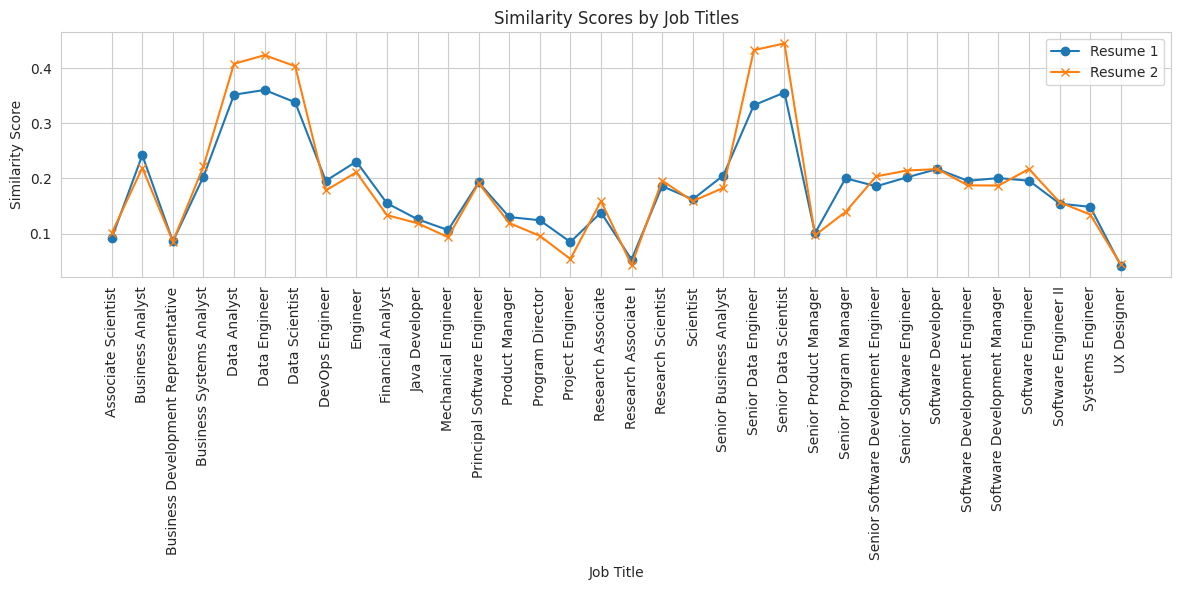

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(df['p_sim_score'], marker='o', label='Resume 1')
plt.plot(df['k_sim_score'], marker='x', label='Resume 2')

plt.title('Similarity Scores by Job Titles')
plt.ylabel('Similarity Score')
plt.xlabel('Job Title')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
unique_elements = set()
repeated_elements = set()

for row in df['combined_skills']:
    for skill in row:
        if skill in unique_elements:
            repeated_elements.add(skill)
        unique_elements.add(skill)

# Removing repeated elements from the unique set
unique_elements -= repeated_elements

# Step 3: Filtering each row's list
df['unique_skills'] = df['combined_skills'].apply(lambda x: [item for item in x if item in unique_elements])
df['unique_skills_len'] = df['combined_skills'].apply(lambda x: len([item for item in x if item in unique_elements]))

# print(df)

In [28]:
df.head()

,Skills,found_skills,Predicted Skills,Skills Length,Found Skills Length,Predicted Skills Length,p_sim_score,k_sim_score,combined_skills,unique_skills,unique_skills_len
Job Title,,,,,,,,,,,
Associate Scientist,"[Bioprocess, Biocompatibility, Electroporation...","[electroporation, cancer immunotherapy, labora...","[bioreactor, programming, building automation,...",52,109,77,0.091787,0.100959,"[protocol, information management, Laboratory ...","[Process Analytical Technology, workforce solu...",34
Business Analyst,"[Adobe Analytics, R, GxP, Business Management,...","[user interface design, html, microsoft operat...","[grace, microsoft operating systems, order man...",204,259,156,0.242263,0.219310,"[human services, resource allocation, Data Pro...","[Oracle Financials, ibm rational, mansfield, q...",89
Business Development Representative,"[Business-to-business, Competitive Pricing, Te...","[business solution, software industry, kronos,...","[sales systems, microbac, programming, smart, ...",33,158,136,0.085902,0.085633,"[Business Development, information management,...","[Business Development, Sales Research, softwar...",83
Business Systems Analyst,"[Software Solutions, R, Technical Troubleshoot...","[html, order management, business solution, da...","[auditing, order management, global developmen...",133,193,159,0.203320,0.221877,"[distributed operations, Information Managemen...","[distributed operations, error recovery, enhan...",60
Data Analyst,"[Software Solutions, GoodData, Server Administ...","[mining, information delivery, supervising, da...","[economic research, managing, insurance, json,...",188,239,151,0.351676,0.407765,"[T-SQL, Information Management, Data Processin...","[information management solutions, Report Desi...",66


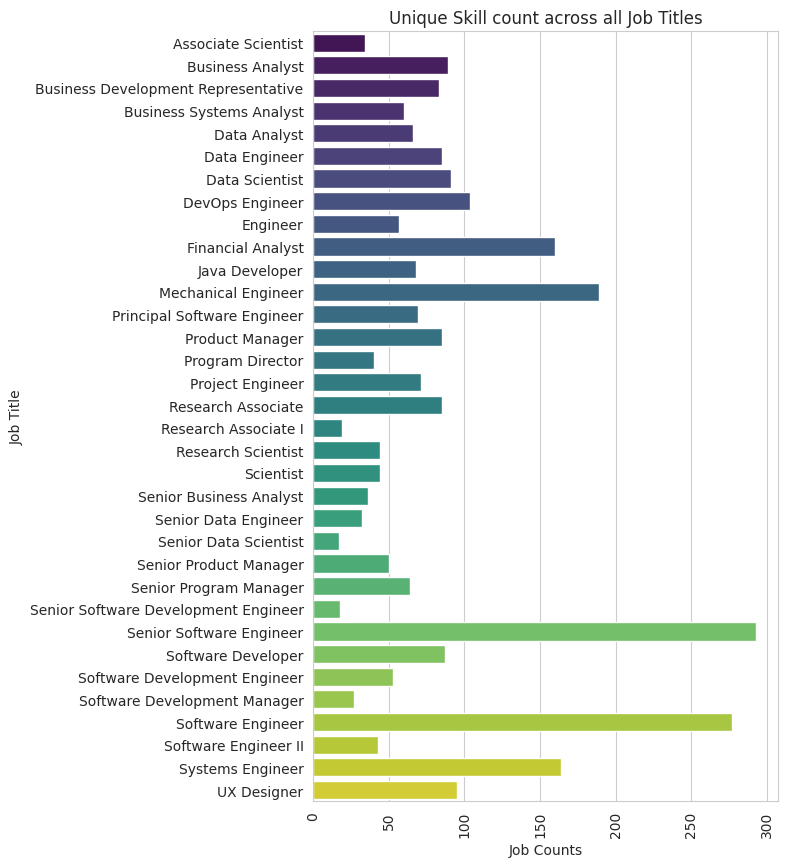

In [29]:
plt.figure(figsize=(6,10))

sns.barplot(x='unique_skills_len', y='Job Title', data=df.reset_index(), palette='viridis')
plt.title('Unique Skill count across all Job Titles')
plt.xlabel('Job Counts')
plt.ylabel('Job Title')
plt.xticks(rotation=90)
plt.show()

In [48]:
print(sorted(df.loc["Data Engineer"]["unique_skills"]))
data_engineer_skills = df.loc["Data Engineer"]["Predicted Skills"]

['Boomi', 'C-tree', 'Control-M', 'DDL', 'Data Dictionary', 'Data Domain', 'Data Quality Assurance', 'Data Vault', 'DataStage', 'Database Scripting', 'Dbx', 'Desktop Development', 'Directory services', 'Effort Estimation', 'Eloqua', 'End-to-end Testing', 'Google BigQuery', 'HANA', 'IT Transformation', 'JPEG', 'Jupyter', 'KNIME', 'MPP', 'Profiling Tools', 'Server Software', 'Spark SQL', 'Star Schema', 'Star Team', 'Teradata SQL', 'TestComplete', 'Transformation Patterns', 'Web Scraping', 'Zephyr', 'ab initio', 'acceleron', 'apache cassandra', 'boomi', 'c2c', 'cadence', 'cambium', 'case study', 'data dictionary', 'data model design', 'data quality assurance', 'data vault', 'database scripting', 'datastage', 'dbx', 'dbx )', 'ddl', 'desktop development', 'directory services', 'effort estimation', 'foundation', 'geis', 'gns', 'google bigquery', 'guidance', 'hana', 'horizon', 'hypertension', 'index', 'itc', 'jpeg', 'jumpcloud', 'jupyter', 'knime', 'knowles', 'linear regression', 'logistic reg

In [49]:
print(sorted(df.loc["Senior Data Engineer"]["unique_skills"]))
senior_data_engineer_skills = df.loc["Senior Data Engineer"]["Predicted Skills"]

['API Based', 'BigTable', 'Cloudera', 'Data Classification', 'Manipulating Data', 'Netezza', 'Palantir', 'SIMON', 'Unix Shell Scripting', 'Wso2', 'apache flink', 'bigtable', 'building analytics', 'building solutions', 'business growth', 'cloudera', 'data classification', 'data power', 'google cloud platform (', 'job creation', 'machine', 'mobile technology', 'municipal', 'netezza', 'oracle systems', 'perks', 'simon', 'spac', 'staffing', 'technical review', 'unix shell scripting', 'wso2']


In [50]:
import pandas as pd
full_list=pd.read_csv("/content/drive/Shareddrives/TM_project/skill_final.csv")
l=full_list['0'].to_list()

In [51]:
for skill in data_engineer_skills:
    if skill not in l:
        print(skill)

blackstone
skills
acceleron
linear regression
trading
continuous learning
technology change
balance
hypertension
building
business operations
autodesk
cervello
stitch
maintenance projects
predictive index
knowles
c2c
talent management
horizon
project life
brightcovers
data
dedication
itc
cadence
dbx )
communication
data foundation
equity
case study
amnesty
geis
query
nuances
storytelling
data engineers
scientific research
raleigh
transparency
platform
index
security clearance
cambium
data model design
uber
monster
capital one
 development
gns
guidance
foundation
profiling
teamwork
test
jumpcloud


In [52]:
for skill in senior_data_engineer_skills:
    if skill not in l:
        print(skill)

business
professional
technical review
continuous learning
staffing
machine
cervello
digital
data power
curiosity
spac
data
mobile technology
business growth
equity
carbon
building solutions
reducing
building analytics
data engineers
municipal
oracle systems
smarts
coaching
application procedures
data technologies
draw
perks
product services
capital one
bioworks
job creation
google cloud platform (
